In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
try:
  df = pd.read_csv('/content/gold_price_data.csv', index_col='Date', parse_dates=True)
except FileNotFoundError:
  print("Error: 'gold_prices.csv' not found. Please upload the file.")
  df = None


In [ ]:
if df is not None:
    print(df.columns)  # Print the column names

Index(['Value'], dtype='object')


In [ ]:
if df is not None:
    # Data preprocessing
    data = df['Value'].values.reshape(-1, 1)  # Replace 'Price' with the correct column name
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)

    # Split into training and testing sets
    train_size = int(len(data_scaled) * 0.8)
    train_data = data_scaled[:train_size]
    test_data = data_scaled[train_size:]

    def create_dataset(dataset, look_back=1):
        X, Y = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), 0]
            X.append(a)
            Y.append(dataset[i + look_back, 0])
        return np.array(X), np.array(Y)

    look_back = 10 # Number of previous time steps to use for prediction
    X_train, Y_train = create_dataset(train_data, look_back)
    X_test, Y_test = create_dataset(test_data, look_back)


In [ ]:
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [ ]:
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
    model.compile(loss='mean_squared_error', optimizer='adam')


In [ ]:
    model.fit(X_train, Y_train, epochs=50, batch_size=32) # Adjust epochs and batch_size as needed


Epoch 1/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0085
Epoch 2/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 7.6044e-05
Epoch 3/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 8.0828e-05
Epoch 4/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 7.6230e-05
Epoch 5/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 9.2963e-05
Epoch 6/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 7.8504e-05
Epoch 7/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 8.1303e-05
Epoch 8/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 7.3348e-05
Epoch 9/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 8.7541e-05
Epoch 10/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 7.1091e-05
Epoch 11/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 7.2751e-05
Epoch 12/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 7.1505e-05
Epoch 13/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 8.0706e-05
Epoch 14/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 5.

In [ ]:
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)


270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [ ]:
    train_predict = scaler.inverse_transform(train_predict)
    Y_train = scaler.inverse_transform([Y_train])
    test_predict = scaler.inverse_transform(test_predict)
    Y_test = scaler.inverse_transform([Y_test])


In [ ]:
    from sklearn.metrics import mean_squared_error
    rmse_train = np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0]))
    rmse_test = np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0]))
    print('Train RMSE: %.2f RMSE' % (rmse_train))
    print('Test RMSE: %.2f RMSE' % (rmse_test))


Train RMSE: 8.66 RMSE
Test RMSE: 16.40 RMSE


In [ ]:
import matplotlib.pyplot as plt
look_back=10
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(data_scaled)-1, :] = test_predict


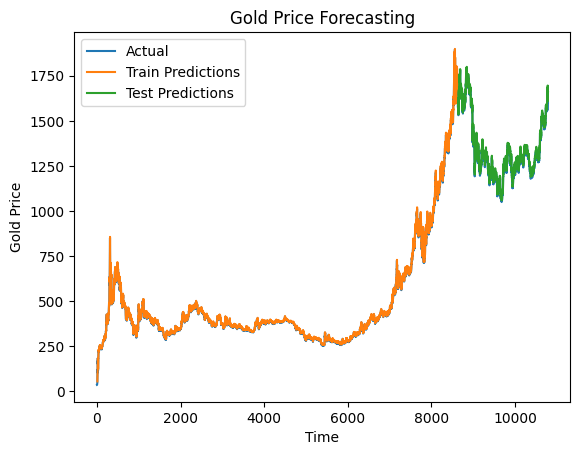

In [ ]:
plt.plot(scaler.inverse_transform(data_scaled), label='Actual')
plt.plot(trainPredictPlot, label='Train Predictions')
plt.plot(testPredictPlot, label='Test Predictions')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Gold Price')
plt.title('Gold Price Forecasting')
plt.show()